In [1]:
## all imports
from IPython.display import HTML
import numpy as np
import urllib2
import bs4 #this is beautiful soup
import socket

from pandas import Series
import pandas as pd
from pandas import DataFrame

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

from secret import *
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException

/Users/anapereira/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Scraping Ticket Line
====================

First, we're going through each event on the website for June and take out the type (concert, workshop, whatever) and url for its specific page, divided by wether it's an event happening once or more times.

In [2]:
events_type_1 = [] #happen just once
events_type_2 = [] #happen more than once
events_url_1 = [] #happen just once
events_url_2 = [] #happen more than once
base_url = 'http://ticketline.sapo.pt'
v = True #going to serve as an indicator of when to stop looking for events
i = 1 #page counter

while v:
    print "page #", i
    url = 'http://ticketline.sapo.pt/pesquisa/?month=6&year=2016&page=' + str(i)
    #change if a different month/year is wanted
    source = urllib2.urlopen(url).read()
    tables = bs4.BeautifulSoup(source, "lxml")
    table_1 = tables.findAll('li', {'class': 'has_multiple_sessions '})
    #for events hapenning more than once, "has_multiple_sessions" is the label
    table_2 = tables.findAll('li', {'class': ' '})
    #for events hapenning once, " " is the label
    if ((table_1==[]) & (table_2==[])): #if it's an empty page, we'll stop the cycle
        v = False
        print("No events on this page.")
    else:
        for t in table_1: 
            ev = t.find('p',{'class': 'metadata categories'})
            events_type_2.append(ev.getText()) #extract the type
            ev = t.find('a').get('href')
            events_url_2.append(base_url + ev) #extract the url
        for t in table_2:
            ev = t.find('p',{'class': 'metadata categories'})
            events_type_1.append(ev.getText())
            ev = t.find('a').get('href')
            events_url_1.append(base_url + ev)
    i = i + 1
        
print "The scraper found %d events!" % (len(events_type_1)+len(events_type_2))
print "There were %d pages with events." % (i-2)
len(events_type_1)+len(events_type_2) == len(events_url_1)+len(events_url_2)

page # 1
page # 2
page # 3
page # 4
page # 5
page # 6
page # 7
No events on this page.
The scraper found 101 events!
There were 6 pages with events.


True

# Event Type - all together

Plotting the events by type, in descending order of frequency.

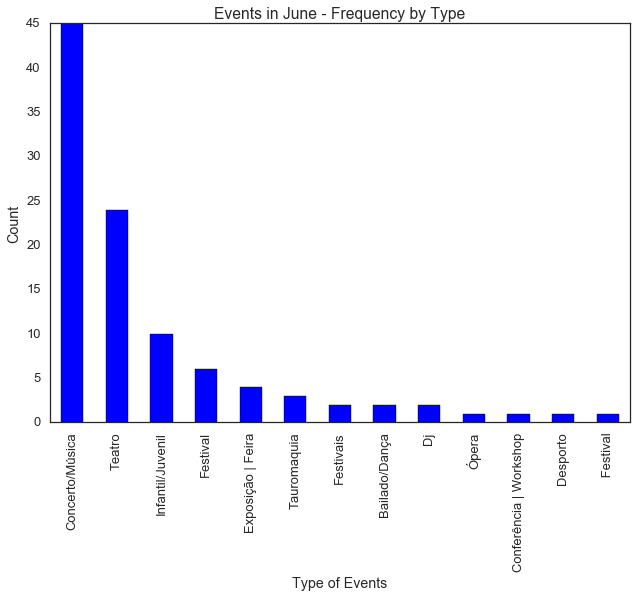

In [3]:
data = pd.Series(events_type_1 + events_type_2)
data2 = data.str.split(',').apply(Series, 1).stack() #some events have more than 1 type, let's separate
#separating increses the number of events. This is 1 way to go, could had left if or kept just the 1st part
data2.index = range(len(data2))
pseries = data2.value_counts()
pseries.sort_values(ascending=False)

pseries.plot(kind = 'bar')
plt.title('Events in June - Frequency by Type')
plt.xlabel('Type of Events')
plt.ylabel('Count')
plt.show()

## Event Type - by Once/More than Once

Plotting the events by type and diving between wether they happen once or more, in descendisng order of the total # of events.

In [4]:
#all events
data = pd.Series(events_type_1 + events_type_2)
data2 = data.str.split(',').apply(Series, 1).stack()
data2.index = range(len(data2))
pseries = data2.value_counts()
pseries.sort_values(ascending=False)
events_all = pd.DataFrame(pseries.index, columns = ["Event Type"])

#events once
data = pd.Series(events_type_1)
data2 = data.str.split(',').apply(Series, 1).stack()
data2.index = range(len(data2))
events_once = pd.DataFrame(data2.value_counts(), columns = ["# Events once"])
events_once['Event Type'] = events_once.index

#events more than once
data = pd.Series(events_type_2)
data2 = data.str.split(',').apply(Series, 1).stack()
data2.index = range(len(data2))
events_MoreOnce = pd.DataFrame(data2.value_counts(), columns = ["# Events more once"])
events_MoreOnce['Event Type'] = events_MoreOnce.index

#joining it all into a data frame - makes it easier to work with
events = events_all.merge(events_once, how = 'outer').merge(events_MoreOnce, how = 'outer')
len(events) == len(events_all)
events = events.fillna(0) #NaN means there were 0 events of that type

(0, 47.0)

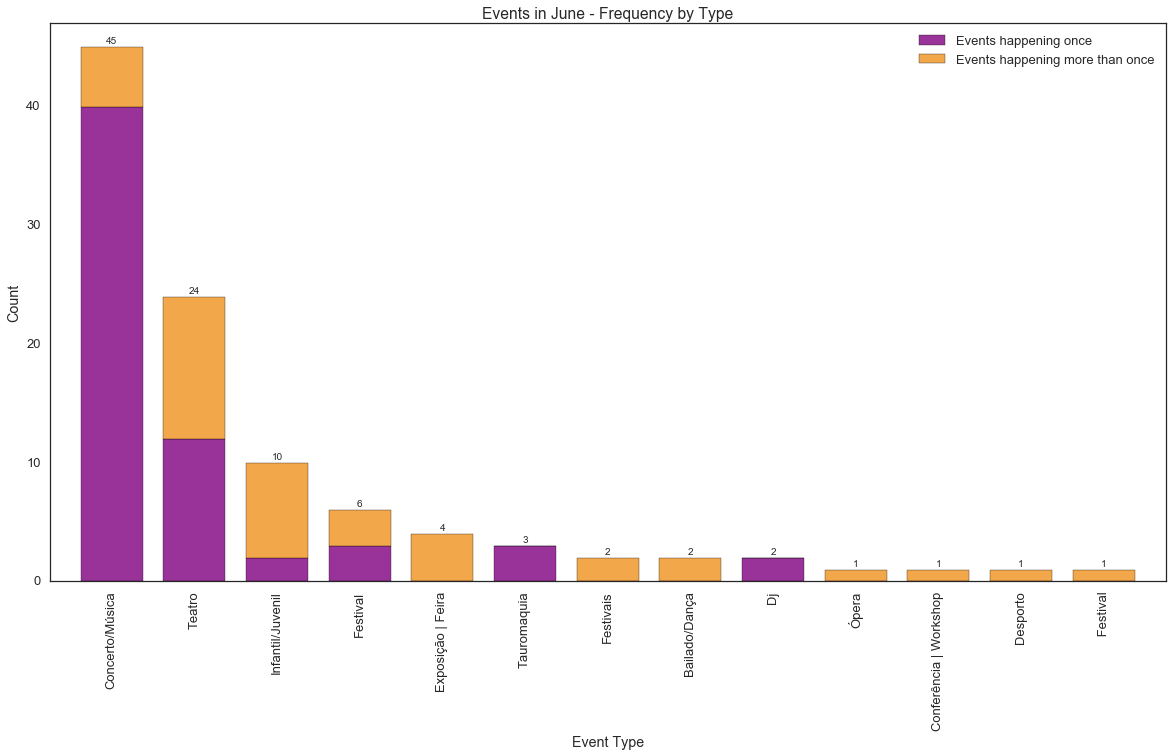

In [5]:
#adapted from http://chrisalbon.com/python/matplotlib_stacked_bar_plot.html
f, ax1 = plt.subplots(1, figsize=(20,10)) # Create the general plot and the "subplots" i.e. the bars
bar_width = 0.75 # Set the bar width
bar_l = [i+1 for i in range(len(events['# Events once']))] # positions of the left bar-boundaries

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 

# Create a bar plot, in position bar_1
ax1.bar(bar_l, events['# Events once'], width=bar_width, label='Events happening once', alpha=0.8, color='purple')

# Create a bar plot, in position bar_1
ax1.bar(bar_l, events['# Events more once'], width=bar_width,bottom=events['# Events once'], 
        label='Events happening more than once', alpha=0.8, color='#F1911E')

plt.xticks(tick_pos, events['Event Type'], rotation=90) # set the x ticks with names
ax1.set_ylabel("Count")
ax1.set_xlabel("Event Type")
plt.legend(loc='upper right')
plt.title('Events in June - Frequency by Type')

#adding the total to the top
Y = (events['# Events more once']+events['# Events once'])
for x,y in zip(tick_pos,Y):
    plt.text(x, y+0.15, '%.0f' % y, ha='center', va= 'bottom')
    
# Set a buffer around the edge
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
plt.ylim([0,(events['# Events more once']+events['# Events once'])[0]+2])

# Prices

Next, we'll use the urls to go to each event's page and take out the prices.

In [6]:
#events happening once
prices_1_min = []
prices_1_max = []
i = 1 #event counter

for link in events_url_1:
    
    #some common errors
    try:
        source = urllib2.urlopen(link).read()
    except urllib2.HTTPError:
        print "HTTPError:"
        continue
    except urllib2.URLError:
        print "URLError:"
        continue
    except socket.error as error:
        print "Connection closed"
        continue
        
    source = urllib2.urlopen(link).read()
    tables = bs4.BeautifulSoup(source, "lxml")
    
    priceRange = tables.find('p', {'class': 'price_range ellipsis'}).getText()
    #get the price range. Often it's not just 1 value, it's something like "3€ a 10€"
    priceRange = priceRange.encode('ascii','ignore').strip('\n').replace(",",".").split("a")
    #split it by the "a" character and turn it into str, convertable to float
    prices_1_min.append(float(priceRange[0]))
    prices_1_max.append(float(priceRange[-1]))
    #if it's 1 price, it'll repeat; if it's more than 1, it'll take the last value

    if i%10==0:
        print len(events_url_1)-i, " events to go"
    i = i+1

52  events to go
42  events to go
32  events to go
22  events to go
12  events to go
2  events to go


In [7]:
#event happening more than once
#for these, the process will be a lot more complicated because a few things can happen:
# 1- price is available right away, in the same format as above (we'll use the same code as above)
# 2- since it's happening in various dates, you might have to pick one before you can see the price in the page 
#(we'll use selenium to click on the calendar)
# 3- even after clicking, a price might not be available (we'll have to check if the element exists)
prices_2_min = []
prices_2_max = []
browser = webdriver.Firefox() #sometimes we'll have to use this || open browser
i = 1 #event counter

for link in events_url_2:
    
    #some common errors
    try:
        source = urllib2.urlopen(link).read()
    except urllib2.HTTPError:
        print "HTTPError:"
        continue
    except urllib2.URLError:
        print "URLError:"
        continue
    except socket.error as error:
        print "Connection closed"
        continue
        
    source = urllib2.urlopen(link).read()
    tables = bs4.BeautifulSoup(source, "lxml")
    
    if tables.find('p', {'class': 'price_range ellipsis'}) is None: 
        #when the price is not available right away, we'll have to use selenium to click on a date in the calendar
        browser.get(link)

        #checking if there is an available date
        val = True
        try:
            browser.find_element_by_xpath("//td[@class = ' available']//a[@class = 'ui-state-default']")
        except NoSuchElementException:
            val = False #if there's no available date

        if val:
            linkElem_aux = browser.find_element_by_xpath("//td[@class = ' available']//a[@class = 'ui-state-default']")
            linkElem_nr = linkElem_aux.text.encode('ascii','ignore') #taking out the first date that's available
            linkElem = browser.find_element_by_xpath("//td[@class = ' available']//a[@class = 'ui-state-default'][text() = " + linkElem_nr + "]")
            linkElem.click() #clicking on it

            priceRange = browser.find_element_by_xpath("//p[@class = 'price_range ellipsis']").text
            #get the price range. Often it's not just 1 value, it's something like "3€ a 10€"
            priceRange = priceRange.encode('ascii','ignore').strip('\n').replace(",",".").split("a") 
            #split it by the "a" character and turn it into str, convertable to float
            prices_2_min.append(float(priceRange[0]))
            prices_2_max.append(float(priceRange[-1])) #if it's 1 price, it'll repeat; if it's more than 1, it'll take the last value
        else: #if there's no date, then there's no price
            prices_2_min.append(np.nan)
            prices_2_max.append(np.nan)

    else: #otherwise, the code for events happening once will work
        priceRange = tables.find('p', {'class': 'price_range ellipsis'}).getText()
        priceRange = priceRange.encode('ascii','ignore').strip('\n').replace(",",".").split("a") 
        prices_2_min.append(float(priceRange[0]))
        prices_2_max.append(float(priceRange[-1]))


    if i%10==0:
        print len(events_url_2)-i, " events to go"
    i = i+1

browser.close() #close the browser

29  events to go
19  events to go
9  events to go


In [8]:
#checking if all the information is there
print len(events_url_1) == len(prices_1_min)
print len(events_url_1) == len(prices_1_max)
print len(events_url_2) == len(prices_2_max)
len(events_url_2) == len(prices_2_min)

True
True
True


True

In [9]:
#just putting the events together with the prices in a data frame
df_Once = pd.DataFrame(columns = ['EventType', 'MinPrice_Once', 'MaxPrice_Once'])
df_Once['EventType'] = events_type_1
df_Once['MinPrice_Once'] = prices_1_min
df_Once['MaxPrice_Once'] = prices_1_max

#here, I'll separate the events that have more than 1 type, as before, while keeping the prices
if df_Once['EventType'].str.split(',').apply(Series, 1).shape[1] == 2:
    df_Once[['EventType_1', 'EventType_2']] = df_Once['EventType'].str.split(',').apply(Series, 1) #separate into 2 columns
    takeOut = df_Once[['EventType_2', 'MinPrice_Once', 'MaxPrice_Once']] #the 2nd types
    takeOut = takeOut[pd.isnull(takeOut['EventType_2']) == False] #just the ones that actually have something
    takeOut.rename(columns={'EventType_2': 'EventType'}, inplace=True) #renaiming it to go back into the dame df
    df_Once.drop('EventType', axis=1, inplace=True) #deleting the old version
    df_Once.drop('EventType_2', axis=1, inplace=True) #deleting the second part
    df_Once.rename(columns={'EventType_1': 'EventType'}, inplace=True) #renaiming the 1st part
    df_Once = pd.concat([df_Once,takeOut]) #put the 2nd part at the end of the previous df
print df_Once.shape[0] == events['# Events once'].sum() #checking if we get the same number of events as before

#just putting the events together with the prices in a data frame
df_MoreOnce = pd.DataFrame(columns = ['EventType', 'MinPrice_MoreOnce', 'MaxPrice_MoreOnce'])
df_MoreOnce['EventType'] = events_type_2
df_MoreOnce['MinPrice_MoreOnce'] = prices_2_min
df_MoreOnce['MaxPrice_MoreOnce'] = prices_2_max

#same ideia as above for spliting event types
if df_MoreOnce['EventType'].str.split(',').apply(Series, 1).shape[1] == 2:
    df_MoreOnce[['EventType_1', 'EventType_2']] = df_MoreOnce['EventType'].str.split(',').apply(Series, 1)
    takeOut = df_MoreOnce[['EventType_2', 'MinPrice_MoreOnce', 'MaxPrice_MoreOnce']]
    takeOut = takeOut[pd.isnull(takeOut['EventType_2']) == False]
    takeOut.rename(columns={'EventType_2': 'EventType'}, inplace=True)
    df_MoreOnce.drop('EventType', axis=1, inplace=True)
    df_MoreOnce.drop('EventType_2', axis=1, inplace=True)
    df_MoreOnce.rename(columns={'EventType_1': 'EventType'}, inplace=True)
    df_MoreOnce = pd.concat([df_MoreOnce,takeOut])
print df_MoreOnce.shape[0] == events['# Events more once'].sum()

True
True


In [10]:
#taking out the events with no price
#actually if one (max/min) is NaN so is the other but I prefer to err on the side of caution
df_MoreOnce = df_MoreOnce[(pd.isnull(df_MoreOnce['MaxPrice_MoreOnce']) == False) & (pd.isnull(df_MoreOnce['MinPrice_MoreOnce']) == False)]
df_Once = df_Once[(pd.isnull(df_Once['MaxPrice_Once']) == False) & (pd.isnull(df_Once['MinPrice_Once']) == False)]

In [11]:
#define the final price column as the mean between the min and max prices
df_Once['Price_Once'] = df_Once['MinPrice_Once'] + (df_Once['MaxPrice_Once'] - df_Once['MinPrice_Once'])/2
df_MoreOnce['Price_MoreOnce'] = df_MoreOnce['MinPrice_MoreOnce'] + (df_MoreOnce['MaxPrice_MoreOnce'] - df_MoreOnce['MinPrice_MoreOnce'])/2

#now we can take out the old columns
df_MoreOnce.drop('MinPrice_MoreOnce', axis=1, inplace=True)
df_MoreOnce.drop('MaxPrice_MoreOnce', axis=1, inplace=True)
df_Once.drop('MinPrice_Once', axis=1, inplace=True)
df_Once.drop('MaxPrice_Once', axis=1, inplace=True)

In [12]:
#putting the metrics (min, max, mean) together
ola1 = pd.DataFrame(df_Once.groupby('EventType').mean().add_prefix('Mean '))
ola1['Event Type'] = ola1.index
ola2 = pd.DataFrame(df_Once.groupby('EventType').max().add_prefix('Max '))
ola2['Event Type'] = ola2.index
ola3 = pd.DataFrame(df_Once.groupby('EventType').min().add_prefix('Min '))
ola3['Event Type'] = ola3.index
merics_Once = pd.merge(pd.merge(ola1,ola2),ola3)

ola1 = pd.DataFrame(df_MoreOnce.groupby('EventType').mean().add_prefix('Mean '))
ola1['Event Type'] = ola1.index
ola2 = pd.DataFrame(df_MoreOnce.groupby('EventType').max().add_prefix('Max '))
ola2['Event Type'] = ola2.index
ola3 = pd.DataFrame(df_MoreOnce.groupby('EventType').min().add_prefix('Min '))
ola3['Event Type'] = ola3.index
merics_MoreOnce = pd.merge(pd.merge(ola1,ola2),ola3)

#and joining them into the main data frame
events = pd.merge(pd.merge(events, merics_MoreOnce, how = 'left'), merics_Once, how = 'left')

In [13]:
#creating the values for the error bars
yerr_Once_1 = events['Mean Price_Once'] - events['Min Price_Once']
yerr_Once_2 = events['Max Price_Once'] - events['Mean Price_Once']
yerr_MoreOnce_1 = events['Mean Price_MoreOnce'] - events['Min Price_MoreOnce']
yerr_MoreOnce_2 = events['Max Price_MoreOnce'] - events['Mean Price_MoreOnce']

(0, 102.0)

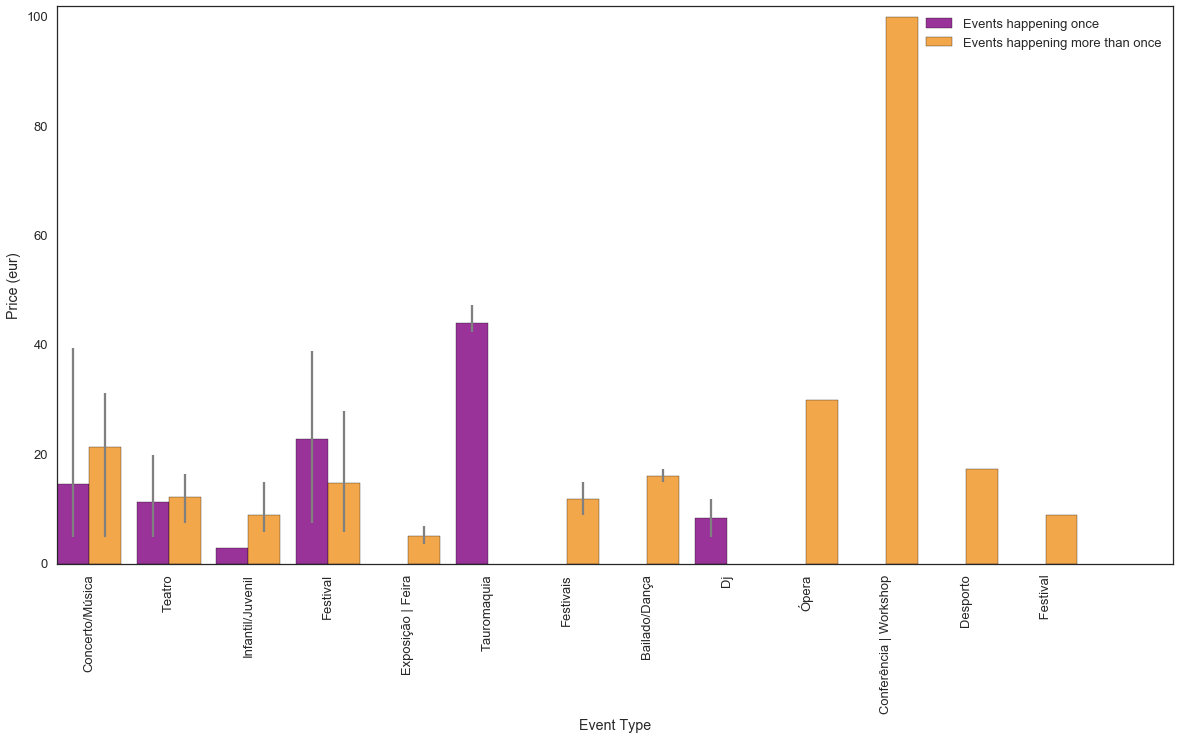

In [18]:
#finally, the plot - the grey line are error bars tracking the max and min prices for each type of event
f, ax1 = plt.subplots(figsize=(20,10)) # Create the general plot and the "subplots" i.e. the bars
bar_width = 0.4 # Set the bar width
pos = list(range(len(events['Mean Price_Once'])))

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [p + bar_width for p in pos] 

# Create a bar plot
ax1.bar(pos, events['Mean Price_Once'], width=bar_width, label='Events happening once', alpha=0.8, color='purple',
       yerr=[yerr_Once_1, yerr_Once_2], ecolor = 'grey')

# Create the other one
ax1.bar([p + bar_width for p in pos], events['Mean Price_MoreOnce'], 
        width=bar_width, label='Events happening more than once', alpha=0.8, color='#F1911E',
        yerr=[yerr_MoreOnce_1, yerr_MoreOnce_2], ecolor = 'grey')

plt.xticks(tick_pos, events['Event Type'], rotation=90) # set the x ticks with names
ax1.set_ylabel("Price (eur)")
ax1.set_xlabel("Event Type")
plt.legend(loc='upper right')

#buffer around edge
plt.ylim([0,max(max(events['Mean Price_Once']), max(events['Mean Price_MoreOnce']))+2])